In [4]:
import os
import pickle

import numpy as np
import numpy.typing as npt
import torch
from torch import Tensor

from autoencoders import DenseAutoencoder, LinearAutoencoder
from scm.box import BoxSCM

import utils

In [5]:
data_dir = "data1"
latent_dim = 64

In [6]:
# Load data generation config
with open(
    os.path.join(data_dir, "generate_data_cfg.pkl"),
    "rb", pickle.HIGHEST_PROTOCOL
) as f:
    data = pickle.load(f)

num_balls: int = data["num_balls"]
n: int = data["n"]
degree: int = data["degree"]
box_size: int = data["box_size"]
intervention_order: npt.NDArray[np.int_] = data["intervention_order"]
n_samples: int = data["n_samples"]
width: int = data["width"]
height: int = data["height"]
ball_radius: int = data["ball_radius"]
# data_dir = data["data_dir"]  # DON'T!! we are supplying this
scm: BoxSCM = data["scm"]

# Ground truth graph
# Note the permutation by the intervention order
dag_gt = scm.adj_mat
dag_gt = dag_gt[intervention_order, :][:, intervention_order]

# Load z and x data
data = np.load(os.path.join(data_dir, "z_and_x.npz"))
zs_obs = data["zs_obs"]
xs_obs = data["xs_obs"]
zs_obs = torch.from_numpy(zs_obs).float()
xs_obs = torch.from_numpy(xs_obs).float().moveaxis(-1, -3) / 255.0
print(f"Loaded z and x data.")
print(f"{zs_obs.shape = }, {xs_obs.shape = }")

Loaded z and x data.
zs_obs.shape = torch.Size([10000, 6]), xs_obs.shape = torch.Size([10000, 3, 64, 64])


In [7]:
# Load the trained autoencoder step 1
autoenc1 = DenseAutoencoder(latent_dim)
autoenc1.load_state_dict(torch.load(os.path.join(data_dir, f"autoenc_reconstruct_{latent_dim}.pth"), weights_only=True))
autoenc1.requires_grad_(False)

encoder1 = autoenc1.get_submodule("encoder").requires_grad_(False)
decoder1 = autoenc1.get_submodule("decoder").requires_grad_(False)

In [8]:
# Load the trained autoencoder step 2
autoenc2 = LinearAutoencoder(n, latent_dim)
autoenc2.load_state_dict(torch.load(os.path.join(data_dir, f"autoenc_disentangle_{latent_dim}.pth"), weights_only=True))
autoenc2.requires_grad_(False)

encoder2 = autoenc2.get_submodule("encoder").requires_grad_(False)
decoder2 = autoenc2.get_submodule("decoder").requires_grad_(False)

In [9]:
encoder = torch.nn.Sequential(encoder1, encoder2)
decoder = torch.nn.Sequential(decoder2, decoder1)

In [10]:
### Part 2: Analysis

## Latent variables recovery
# Mean correlation coefficient
zhats_obs = encoder(xs_obs)
assert isinstance(zhats_obs, Tensor)
z_mcc = utils.mcc(zhats_obs.detach().cpu().numpy(), zs_obs.detach().cpu().numpy())
print(f"{z_mcc = }")

z_mcc = np.float32(0.2719686)


See tensor(6256) for overlap

In [21]:
idx = torch.randint(0, zs_obs.shape[0], ())
idx

tensor(5838)

In [22]:
zhat_idx = encoder(xs_obs[idx:idx+1])[0]
xhat_idx = decoder(zhat_idx.unsqueeze(0))[0]

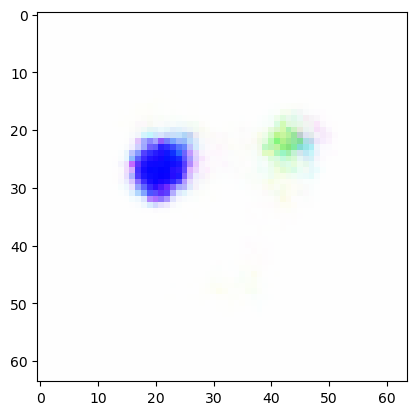

In [23]:
import matplotlib.pyplot as plt

plt.imshow(xhat_idx.detach().cpu().moveaxis(-3, -1).numpy())

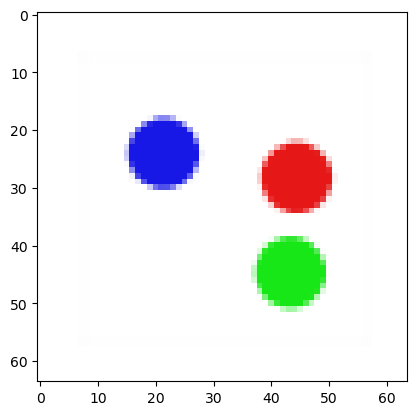

In [24]:
plt.imshow(xs_obs[idx].detach().cpu().moveaxis(-3, -1).numpy())

In [25]:
zs_obs[:10], zhats_obs[:10]

(tensor([[-0.2447, -0.1873, -0.3058, -0.0640, -0.4820, -0.1218],
         [-0.4220,  0.0389, -0.1499,  0.0599, -0.4004,  0.1245],
         [-0.2891,  0.1641,  0.4887,  0.3016,  0.2038, -0.4741],
         [ 0.4978, -0.0373, -0.0117, -0.1052, -0.3175,  0.1177],
         [-0.0349,  0.3333, -0.2572,  0.2673, -0.3485, -0.1109],
         [-0.1917,  0.0231,  0.1623, -0.2657,  0.1474,  0.2621],
         [ 0.2605,  0.3943, -0.0209, -0.1354,  0.3394, -0.2437],
         [ 0.4353, -0.2990,  0.2595, -0.1460,  0.2303,  0.0679],
         [ 0.1649,  0.4964,  0.3130, -0.0583, -0.3802,  0.4139],
         [ 0.1021,  0.3934, -0.1169, -0.4677,  0.2859, -0.3870]]),
 tensor([[ 0.6817, -0.4396, -0.4761,  0.8062,  0.1399,  0.8225],
         [-0.0534, -1.0100,  0.0598,  0.1808, -0.9394,  1.2894],
         [ 0.2720, -0.2647,  0.0167, -0.6234,  0.6543,  1.8700],
         [-0.5027, -0.5904,  0.3067,  0.7527, -1.5098,  1.5229],
         [ 1.0286, -0.2895, -0.6340, -0.3271, -0.1741,  1.2955],
         [-0.0411,  0.1